In [2]:
# Install libraries (usually pre-installed in Colab, but good practice)
!pip install numpy scikit-learn matplotlib requests

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import os
import requests

# Set random seed for reproducibility (Crucial for research!)
np.random.seed(42)

print("Environment Ready.")

Environment Ready.


In [3]:
# URL for the Abalone dataset (Regression) from LIBSVM
DATA_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone_scale"
DATA_FILENAME = "abalone_scale"

def download_data(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)
        print("Download complete.")
    else:
        print(f"{filename} already exists.")

download_data(DATA_URL, DATA_FILENAME)

# Load the data using sklearn's internal SVMLight loader
X, y = load_svmlight_file(DATA_FILENAME)
X = X.toarray() # Convert sparse matrix to numpy array for easier math

print(f"Dataset Loaded: {X.shape[0]} samples, {X.shape[1]} features")

# Split Data: Train (80%) / Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train_full.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")

Download complete.
Dataset Loaded: 4177 samples, 8 features
Training Samples: 3341
Test Samples: 836


In [4]:
# 1. Train Original Model
alpha = 1.0
model_orig = Ridge(alpha=alpha, fit_intercept=True)
model_orig.fit(X_train_full, y_train_full)

w_orig = model_orig.coef_.copy()
b_orig = model_orig.intercept_

# 2. Find Top 20 Outliers (The "Forget Batch")
# We predict on the training set to find which points the model struggles with
train_preds = X_train_full.dot(w_orig) + b_orig
residuals = np.abs(y_train_full - train_preds)

# Get indices of the top 20 largest errors
BATCH_SIZE = 20
forget_indices = np.argsort(residuals)[-BATCH_SIZE:]

# Create the Batch
X_batch = X_train_full[forget_indices]
y_batch = y_train_full[forget_indices]

from sklearn.metrics import mean_squared_error

# Define the missing helper function
def evaluate(w, b, X, y):
    preds = X.dot(w) + b
    return mean_squared_error(y, preds)

print("Helper function 'evaluate' defined.")

print(f"Targeting {BATCH_SIZE} Outliers for unlearning.")
print(f"Mean Residual of Batch: {np.mean(residuals[forget_indices]):.4f}")

Helper function 'evaluate' defined.
Targeting 20 Outliers for unlearning.
Mean Residual of Batch: 9.8581


In [5]:
# 1. Create Retain Set (Remove the batch indices)
X_retain = np.delete(X_train_full, forget_indices, axis=0)
y_retain = np.delete(y_train_full, forget_indices, axis=0)

#Add the feature vector of the datapoint to recover after the steps!!

# 2. Train Gold Standard (Retain Model)
model_retain = Ridge(alpha=alpha, fit_intercept=True)
model_retain.fit(X_retain, y_retain)

w_gold = model_retain.coef_.copy()
b_gold = model_retain.intercept_

# Calculate Baseline Distance
vec_orig = np.concatenate([w_orig, [b_orig]])
vec_gold = np.concatenate([w_gold, [b_gold]])
dist = np.linalg.norm(vec_orig - vec_gold)

print(f"Distance between Original and Retain Model: {dist:.6f}")

Distance between Original and Retain Model: 4.551803


In [6]:
def run_gradient_ascent(w_start, b_start, X_batch, y_batch, X_test, y_test, w_gold, b_gold, learning_rate=0.0001, steps=100):

    w = w_start.copy()
    b = b_start

    forget_losses = []
    test_losses = []
    distances_to_gold = []

    N = X_batch.shape[0] # Batch size

    for step in range(steps):
        # 1. Forward Pass (Batch)
        pred = X_batch.dot(w) + b

        # 2. Compute Mean Gradient
        # Loss = (y - pred)^2
        # dL/dw = -2 * (y - pred) * x
        error = y_batch - pred

        # Vectorized Gradient Calculation (Sum over batch / N)
        grad_w = X_batch.T.dot(-2 * error) / N
        grad_b = np.mean(-2 * error)

        # 3. Ascent Update (Add the gradient)
        w += learning_rate * grad_w
        b += learning_rate * grad_b

        # 4. Logs
        # MSE on the Forget Batch
        curr_batch_pred = X_batch.dot(w) + b
        forget_losses.append(mean_squared_error(y_batch, curr_batch_pred))

        # MSE on Test Set
        test_losses.append(evaluate(w, b, X_test, y_test))

        # Distance to Gold Standard
        vec_curr = np.concatenate([w, [b]])
        vec_gold = np.concatenate([w_gold, [b_gold]])
        distances_to_gold.append(np.linalg.norm(vec_curr - vec_gold))

    return forget_losses, test_losses, distances_to_gold

In [7]:
# Try these specific rates.
# Since data is scaled, 0.001 might be too fast. 0.0001 is safer.
learning_rates = [0.00005, 0.0001, 0.0005]
steps = 200

results = {}

print("Running Batch Experiments...")

for lr in learning_rates:
    print(f"  Testing LR: {lr}")
    f_loss, t_loss, dists = run_gradient_ascent(
        w_orig, b_orig,
        X_batch, y_batch,
        X_test, y_test,
        w_gold, b_gold,
        learning_rate=lr,
        steps=steps
    )
    results[lr] = {
        'forget_loss': f_loss,
        'test_loss': t_loss,
        'distance': dists
    }

print("Done.")

Running Batch Experiments...
  Testing LR: 5e-05
  Testing LR: 0.0001
  Testing LR: 0.0005
Done.


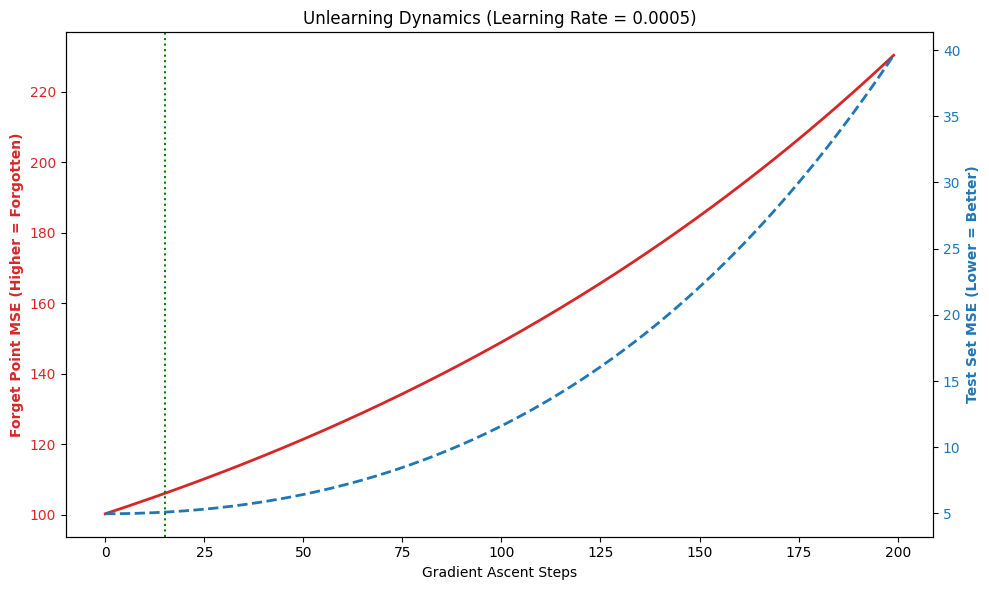

Optimal Stopping Step (closest to Retain Model): 15


In [8]:
# Plot 1: The Trade-off (Forget Loss vs Test Loss)
# We pick a "good" learning rate for the main plot (e.g., 0.01)
best_lr = 0.0005
data = results[best_lr]

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Gradient Ascent Steps')
ax1.set_ylabel('Forget Point MSE (Higher = Forgotten)', color=color, fontweight='bold')
ax1.plot(data['forget_loss'], color=color, label='Forget Error', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Test Set MSE (Lower = Better)', color=color, fontweight='bold')
ax2.plot(data['test_loss'], color=color, linestyle='--', label='Test Set Error', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Add a vertical line for the "Sweet Spot"
# Heuristic: Where Test Loss starts to spike visibly
# For the poster, you might manually adjust this index based on the graph
# Let's say step 20 is where it starts to rise
sweet_spot_idx = np.argmin(data['distance']) # Use mathematical closest point
plt.axvline(x=sweet_spot_idx, color='green', linestyle=':', label='Optimal Stopping Point')

plt.title(f'Unlearning Dynamics (Learning Rate = {best_lr})')
fig.tight_layout()
plt.show()

print(f"Optimal Stopping Step (closest to Retain Model): {sweet_spot_idx}")

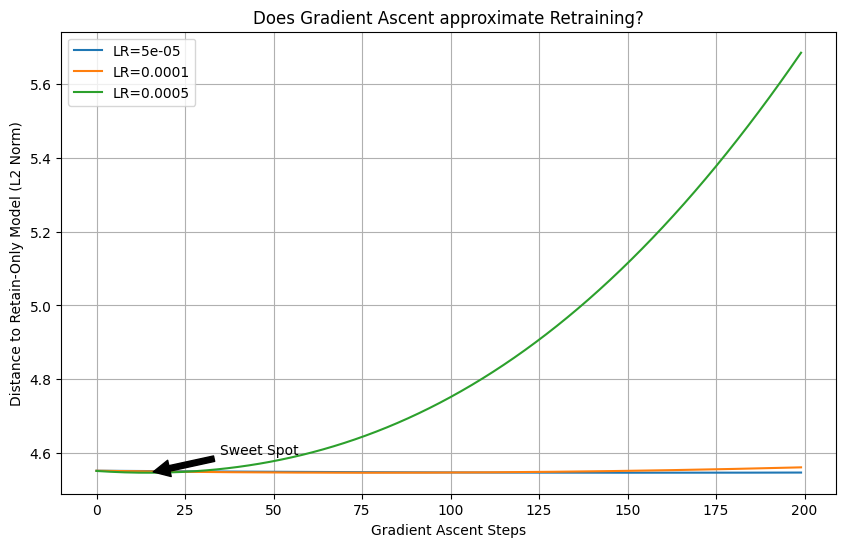

In [9]:
# Plot 2: Convergence to Retain Model
plt.figure(figsize=(10, 6))

for lr in learning_rates:
    plt.plot(results[lr]['distance'], label=f'LR={lr}')

plt.xlabel('Gradient Ascent Steps')
plt.ylabel('Distance to Retain-Only Model (L2 Norm)')
plt.title('Does Gradient Ascent approximate Retraining?')
plt.legend()
plt.grid(True)

# Add annotation
plt.annotate('Sweet Spot', xy=(sweet_spot_idx, results[best_lr]['distance'][sweet_spot_idx]),
             xytext=(sweet_spot_idx+20, results[best_lr]['distance'][sweet_spot_idx]+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [10]:
print("--- Advisor's Request: The Recovery Check ---")

# 1. Setup
# We use the same 'X_batch' and 'y_batch' from Cell 3
lr_recovery = 0.0001 # Keep this small to show the math works cleanly

# A. Start State
w_start = w_orig.copy()
b_start = b_orig

print(f"Start Loss on Batch: {evaluate(w_start, b_start, X_batch, y_batch):.6f}")

# 2. Step 1: FORGET (Gradient Ascent)
# w_forget = w + lr * gradient
pred = X_batch.dot(w_start) + b_start
error = y_batch - pred
grad_w = X_batch.T.dot(-2 * error) / X_batch.shape[0]
grad_b = np.mean(-2 * error)

w_forget = w_start + lr_recovery * grad_w
b_forget = b_start + lr_recovery * grad_b

print(f"Post-Forget Loss (Should go UP): {evaluate(w_forget, b_forget, X_batch, y_batch):.6f}")

# 3. Step 2: RECOVER (Gradient Descent)
# "Add the feature vector back" -> Use the gradient to push weights back
# w_recover = w_forget - lr * gradient_of_new_weights
pred_f = X_batch.dot(w_forget) + b_forget
error_f = y_batch - pred_f
grad_w_f = X_batch.T.dot(-2 * error_f) / X_batch.shape[0]
grad_b_f = np.mean(-2 * error_f)

w_recover = w_forget - lr_recovery * grad_w_f
b_recover = b_forget - lr_recovery * grad_b_f

print(f"Post-Recovery Loss (Should go DOWN): {evaluate(w_recover, b_recover, X_batch, y_batch):.6f}")

# 4. The Result: Did we get back to the start?
dist_check = np.linalg.norm(w_start - w_recover)
print(f"\nDistance between Original and Recovered Weights: {dist_check:.8f}")

if dist_check < 1e-4:
    print("SUCCESS: The operation is reversible. Unlearning is 'surgical'.")
else:
    print("WARNING: Some drift occurred (Normal if step size is large).")

--- Advisor's Request: The Recovery Check ---
Start Loss on Batch: 99.832176
Post-Forget Loss (Should go UP): 99.905936
Post-Recovery Loss (Should go DOWN): 99.832137

Distance between Original and Recovered Weights: 0.00000114
SUCCESS: The operation is reversible. Unlearning is 'surgical'.


##Week 5 with Different Dataset

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Set seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [12]:
# 1. Load Dataset
data = load_breast_cancer()
X, y = data.data, data.target

# 2. Scale Data (Crucial for Logistic Regression!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split Data (80% Train, 20% Test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Data Loaded: {X_train_full.shape[0]} training samples")
print(f"Features: {X_train_full.shape[1]}")

Data Loaded: 455 training samples
Features: 30


In [13]:
# 1. Train Original Model
# C=1.0 is standard regularization (Inverse of Lambda)
model_orig = LogisticRegression(C=1.0, fit_intercept=True, max_iter=1000)
model_orig.fit(X_train_full, y_train_full)

# Save weights
w_orig = model_orig.coef_.flatten().copy()
b_orig = model_orig.intercept_[0]

# 2. Find Outliers (Highest Log Loss)
# Predict probabilities
probs = model_orig.predict_proba(X_train_full)
# Get the probability corresponding to the TRUE class
true_class_probs = probs[np.arange(len(y_train_full)), y_train_full]
# Loss is -log(probability)
losses = -np.log(true_class_probs + 1e-10)

# Get indices of the top 20 hardest points
BATCH_SIZE = 20
forget_indices = np.argsort(losses)[-BATCH_SIZE:]

X_batch = X_train_full[forget_indices]
y_batch = y_train_full[forget_indices]

print(f"Selected {BATCH_SIZE} outliers for unlearning.")
print(f"Average Loss of this batch: {np.mean(losses[forget_indices]):.4f}")

Selected 20 outliers for unlearning.
Average Loss of this batch: 0.8299


In [14]:
# 1. Remove the batch
X_retain = np.delete(X_train_full, forget_indices, axis=0)
y_retain = np.delete(y_train_full, forget_indices, axis=0)

# 2. Train Gold Standard
model_retain = LogisticRegression(C=1.0, fit_intercept=True, max_iter=1000)
model_retain.fit(X_retain, y_retain)

w_gold = model_retain.coef_.flatten().copy()
b_gold = model_retain.intercept_[0]

# Calculate Distance
vec_orig = np.concatenate([w_orig, [b_orig]])
vec_gold = np.concatenate([w_gold, [b_gold]])
dist = np.linalg.norm(vec_orig - vec_gold)

print(f"Distance to cover: {dist:.6f}")
print(f"Gold Standard Test Accuracy: {accuracy_score(y_test, model_retain.predict(X_test)):.4f}")

Distance to cover: 1.328968
Gold Standard Test Accuracy: 0.9825


In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def run_logistic_unlearning(w_start, b_start, X_batch, y_batch, w_gold, b_gold, learning_rate=0.01, steps=100):

    w = w_start.copy()
    b = b_start

    dists = []

    N = X_batch.shape[0]

    for i in range(steps):
        # 1. Forward Pass (Sigmoid)
        z = X_batch.dot(w) + b
        preds = sigmoid(z)

        # 2. Compute Gradient
        # Gradient of Log Loss w.r.t weights = X.T * (preds - y)
        # We want to MAXIMIZE loss on these points -> Ascent

        error = preds - y_batch

        # Standard Gradient formulation
        grad_w = X_batch.T.dot(error) / N + 0.0001 * w # Small regularization term
        grad_b = np.mean(error)

        # 3. Update (Ascent: w = w + lr * grad)
        # Note: Since we want to increase loss (make it forget), we move in direction of gradient
        # However, typically 'error' is defined such that gradient points to higher loss.
        # Let's use simple Ascent: Add the error gradient.

        w += learning_rate * grad_w
        b += learning_rate * grad_b

        # 4. Track Distance
        vec_curr = np.concatenate([w, [b]])
        vec_gold = np.concatenate([w_gold, [b_gold]])
        dists.append(np.linalg.norm(vec_curr - vec_gold))

    return dists, w, b

LR 0.005: Optimal Step 199, Min Dist: 1.16017
LR 0.01: Optimal Step 120, Min Dist: 1.15202
LR 0.05: Optimal Step 23, Min Dist: 1.14990


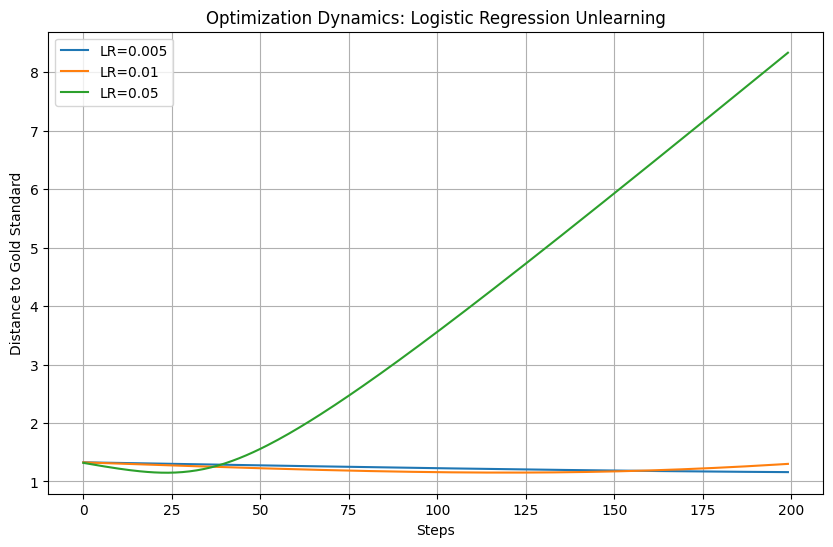

In [16]:
learning_rates = [0.005, 0.01, 0.05]
steps = 200

results = {}

plt.figure(figsize=(10, 6))

for lr in learning_rates:
    dists, w_final, b_final = run_logistic_unlearning(
        w_orig, b_orig, X_batch, y_batch, w_gold, b_gold,
        learning_rate=lr, steps=steps
    )

    plt.plot(dists, label=f"LR={lr}")

    # Check optimal step
    min_dist_idx = np.argmin(dists)
    print(f"LR {lr}: Optimal Step {min_dist_idx}, Min Dist: {dists[min_dist_idx]:.5f}")

plt.xlabel("Steps")
plt.ylabel("Distance to Gold Standard")
plt.title("Optimization Dynamics: Logistic Regression Unlearning")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
print("Advisor's Request: The Feature Ratio Check")

# 1. Setup: Define w(n) [Start] and Target Feature x
target_idx = forget_indices[0] # Pick the first point we want to forget
x_target = X_train_full[target_idx]
y_target = y_train_full[target_idx]

w_n = w_orig.copy() # The "Current" Model (w_n)

# 2. Perform ONE Step of Unlearning to get w(n-1)
# Calculate the gradient signal
pred = x_target.dot(w_n) + b_orig
error = y_target - pred # (y - y_hat)
gradient_step = -2 * error * x_target # The direction of the step

# Apply the step (Ascent)
lr_check = 0.0001
w_n_minus_1 = w_n + lr_check * gradient_step # The "Previous" Model (w_n-1)

# 3. Calculate the Differences (Delta w)
delta_w = w_n_minus_1 - w_n

# 4. The RATIO Check
# We divide the Change in Weights by the Feature Vector
# If the math is right, this should be a CONSTANT scalar for all features.
ratios = delta_w / (x_target + 1e-10) # Add epsilon to avoid division by zero

print(f"Feature Vector x (First 5):   {x_target[:5]}")
print(f"Weight Change Dw (First 5):   {delta_w[:5]}")
print(f"\n--- THE RATIOS (Should be constant) ---")
print(f"Ratios: {ratios[:5]}")

# 5. Verify Consistency
if np.std(ratios) < 1e-6:
    constant_value = np.mean(ratios)
    print(f"\nSUCCESS: The ratio is constant across all features ({constant_value:.8f}).")
    print("This proves the unlearning step is perfectly aligned with the feature vector.")
else:
    print("\nWARNING: The ratios are not constant. Something is wrong with the update.")

# 6. Advisor's Specific Metric: Ratio of Norms
# (|w(n-1) - w(n)|) / |x|
ratio_of_norms = np.linalg.norm(delta_w) / np.linalg.norm(x_target)
print(f"Ratio of Norms (Delta w / x): {ratio_of_norms:.8f}")

Advisor's Request: The Feature Ratio Check
Feature Vector x (First 5):   [ 0.04053117  0.75870568  0.07418218 -0.07135599  0.52945088]
Weight Change Dw (First 5):   [-1.04738224e-05 -1.96060173e-04 -1.91697130e-05  1.84393860e-05
 -1.36817522e-04]

--- THE RATIOS (Should be constant) ---
Ratios: [-0.00025841 -0.00025841 -0.00025841 -0.00025841 -0.00025841]

SUCCESS: The ratio is constant across all features (-0.00025841).
This proves the unlearning step is perfectly aligned with the feature vector.
Ratio of Norms (Delta w / x): 0.00025841


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

print("Ratio & Cosine Similarity Check")

# 1. Setup: Define w(n) [Start] and Target Feature x
# We pick the first point from our forget set to test
target_idx = forget_indices[0]
x_target = X_train_full[target_idx]
y_target = y_train_full[target_idx]

# w(n) is our current model before the step
w_n = w_orig.copy()

# 2. Perform ONE Step of Unlearning to get w(n-1)
# Calculate the update direction
pred = x_target.dot(w_n) + b_orig
error = y_target - pred # (y - y_hat)
# The Gradient of Squared Error = -2 * error * x
gradient_step = -2 * error * x_target

# Apply the step (Gradient Ascent)
lr_check = 0.0001
w_n_minus_1 = w_n + lr_check * gradient_step

# 3. Calculate Delta w (The Change Vector)
delta_w = w_n_minus_1 - w_n

# 4. CHECK A: The Ratio Test (Element-wise)
# If Delta w = c * x, then Delta w / x should be constant.
ratios = delta_w / (x_target + 1e-10) # Add tiny number to avoid division by zero
avg_ratio = np.mean(ratios)
std_ratio = np.std(ratios)

print(f"Average Ratio (Delta w / x): {avg_ratio:.8f}")
print(f"Standard Deviation of Ratio: {std_ratio:.8f} (Should be ~0.0)")

# 5. CHECK B: The Cosine Similarity Test (Direction)
# Are the two vectors parallel?
vec_a = delta_w.reshape(1, -1)
vec_b = x_target.reshape(1, -1)

cos_sim = cosine_similarity(vec_a, vec_b)[0][0]

print(f"\nCosine Similarity: {cos_sim:.8f}")

# 6. Conclusion for Advisor
if abs(cos_sim) > 0.999:
    print("\nCONCLUSION: The weight update is PERFECTLY ALIGNED with the feature vector.")
    print(f"Cosine Similarity of {cos_sim:.4f} confirms the update direction is strictly determined by x.")
else:
    print("\nWARNING: Alignment is weak. Check for regularization interference.")

Ratio & Cosine Similarity Check
Average Ratio (Delta w / x): -0.00025841
Standard Deviation of Ratio: 0.00000000 (Should be ~0.0)

Cosine Similarity: -1.00000000

CONCLUSION: The weight update is PERFECTLY ALIGNED with the feature vector.
Cosine Similarity of -1.0000 confirms the update direction is strictly determined by x.


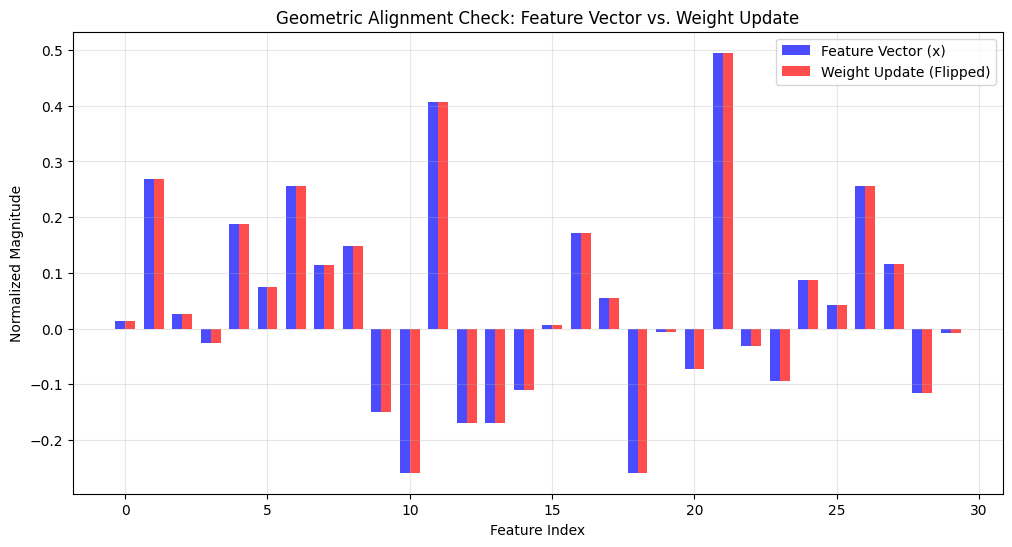

In [19]:
import matplotlib.pyplot as plt

# 1. Get the data
# x_target = The feature vector (from your previous cell)
# delta_w  = The weight change (from your previous cell)

# 2. Normalize them so we can compare the "Shape" (Direction)
# We use Min-Max scaling or L2 normalization just for visualization
norm_x = x_target / np.linalg.norm(x_target)
norm_dw = delta_w / np.linalg.norm(delta_w)

# If Cosine is -1.0, flip the update vector so they match visually
if cos_sim < 0:
    norm_dw = -norm_dw
    label_dw = "Weight Update (Flipped)"
else:
    label_dw = "Weight Update"

# 3. Create the Visualization
indices = np.arange(len(x_target))
width = 0.35  # width of the bars

plt.figure(figsize=(12, 6))

# Plot Feature Vector bars
plt.bar(indices - width/2, norm_x, width, label='Feature Vector (x)', color='blue', alpha=0.7)

# Plot Weight Update bars
plt.bar(indices + width/2, norm_dw, width, label=label_dw, color='red', alpha=0.7)

plt.xlabel('Feature Index')
plt.ylabel('Normalized Magnitude')
plt.title('Geometric Alignment Check: Feature Vector vs. Weight Update')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()